# Titanic


# Download kaggle data

In [332]:
import os

os.environ["KAGGLE_CONFIG_DIR"] = os.path.join("drive", "My Drive", "Kaggle")

In [333]:
assert os.path.isfile(os.path.join(os.environ["KAGGLE_CONFIG_DIR"], "kaggle.json"))

In [334]:
%pip install kaggle

In [335]:
!kaggle competitions download -c titanic -p data

test.csv: Skipping, found more recently modified local copy (use --force to force download)
gender_submission.csv: Skipping, found more recently modified local copy (use --force to force download)
train.csv: Skipping, found more recently modified local copy (use --force to force download)


In [336]:
!ls -alFh data

total 100K
drwxr-xr-x 2 root root 4.0K Feb 17 23:59 ./
drwxr-xr-x 1 root root 4.0K Feb 18 01:14 ../
-rw-r--r-- 1 root root 3.2K Feb 17 23:59 gender_submission.csv
-rw-r--r-- 1 root root  28K Feb 17 23:59 test.csv
-rw-r--r-- 1 root root  60K Feb 17 23:59 train.csv


# Check Tensorflow version

In [337]:
import packaging.version
import tensorflow as tf

assert packaging.version.parse(tf.version.VERSION).major >= 2, \
    "This notebook requires TensorFlow 2.0 or above."

In [338]:
print("Tensorflow version:", tf.version.VERSION)
print("Tensorflow support GPU :", tf.test.is_built_with_gpu_support())
print("List GPUs :", tf.config.list_physical_devices('GPU'))

Tensorflow version: 2.4.1
Tensorflow support GPU : True
List GPUs : []


# Import libraries

In [339]:
import numpy as np
import pandas as pd

# Make numpy values easier to read.
np.set_printoptions(precision=5, suppress=True)

In [340]:
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing

In [341]:
import matplotlib.pyplot as plt
import seaborn as sns

In [342]:
import missingno as msno

# Load extension

In [343]:
%matplotlib inline

# Load CSV

In [344]:
DATA_DIR = "./data"

TRAIN_FILE_PATH = os.path.join(DATA_DIR, "train.csv")
TEST_FILE_PATH = os.path.join(DATA_DIR, "test.csv")

In [345]:
original_train_df = pd.read_csv(TRAIN_FILE_PATH)
original_test_df = pd.read_csv(TEST_FILE_PATH)

# View trianing data

In [346]:
LABEL_NAME = "Survived"

In [347]:
original_train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [348]:
original_train_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


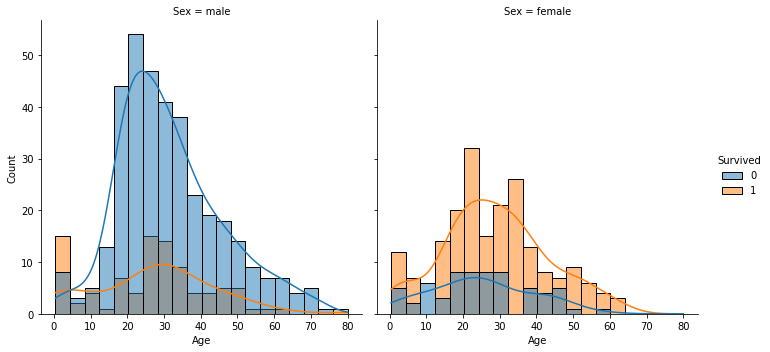

In [349]:
sns.displot(data=original_train_df, x="Age", hue="Survived", col="Sex", kind="hist", kde=True)

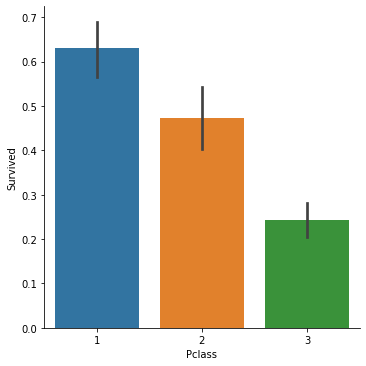

In [350]:
sns.catplot(data=original_train_df, x="Pclass", y="Survived", kind="bar")

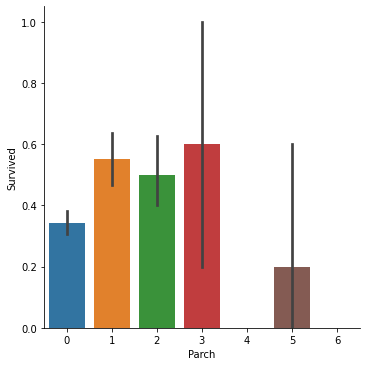

In [351]:
sns.catplot(data=original_train_df, x="Parch", y="Survived", kind="bar")

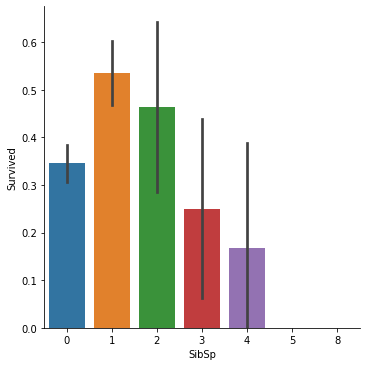

In [352]:
sns.catplot(data=original_train_df, x="SibSp", y="Survived", kind="bar")

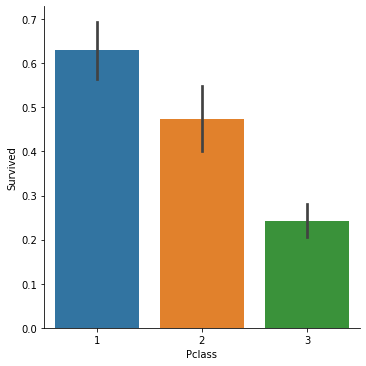

In [353]:
sns.catplot(data=original_train_df, x="Pclass", y="Survived", kind="bar")

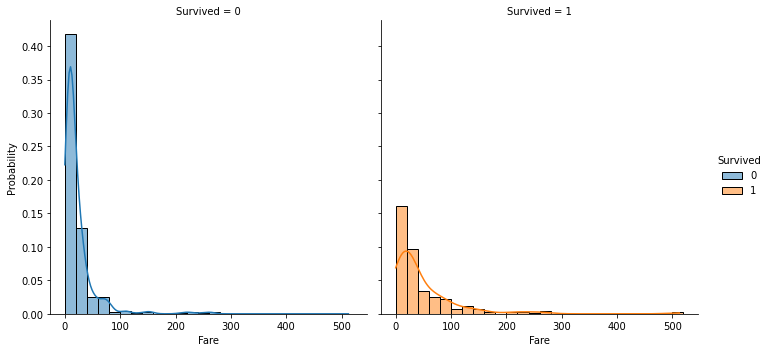

In [354]:
sns.displot(data=original_train_df,
    x="Fare",
    hue="Survived",
    kind="hist",
    kde=True,
    binwidth=20,
    stat="probability",
    col="Survived"
)

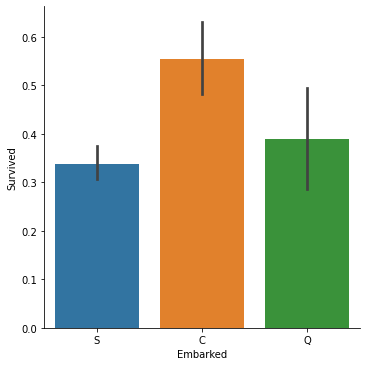

In [355]:
sns.catplot(data=original_train_df, x="Embarked", y="Survived", kind="bar")

# Check missing values in test data

In [356]:
original_test_df = pd.read_csv(TEST_FILE_PATH)
original_test_df

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...
413,1305,3,"Spector, Mr. Woolf",male,NaN,0,0,A.5. 3236,8.0500,NaN,S
414,1306,1,"Oliva y Ocana, Dona. Fermina",female,39.0,0,0,PC 17758,108.9000,C105,C
415,1307,3,"Saether, Mr. Simon Sivertsen",male,38.5,0,0,SOTON/O.Q. 3101262,7.2500,NaN,S
416,1308,3,"Ware, Mr. Frederick",male,NaN,0,0,359309,8.0500,NaN,S


In [357]:
original_test_df.isna().sum()

PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64

# Preprocess data

## Merge all data for imputation and feature engineering

In [358]:
base_all_df = pd.concat([original_train_df, original_test_df], axis=0)

In [359]:
base_all_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1309 entries, 0 to 417
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  1309 non-null   int64  
 1   Survived     891 non-null    float64
 2   Pclass       1309 non-null   int64  
 3   Name         1309 non-null   object 
 4   Sex          1309 non-null   object 
 5   Age          1046 non-null   float64
 6   SibSp        1309 non-null   int64  
 7   Parch        1309 non-null   int64  
 8   Ticket       1309 non-null   object 
 9   Fare         1308 non-null   float64
 10  Cabin        295 non-null    object 
 11  Embarked     1307 non-null   object 
dtypes: float64(3), int64(4), object(5)
memory usage: 132.9+ KB


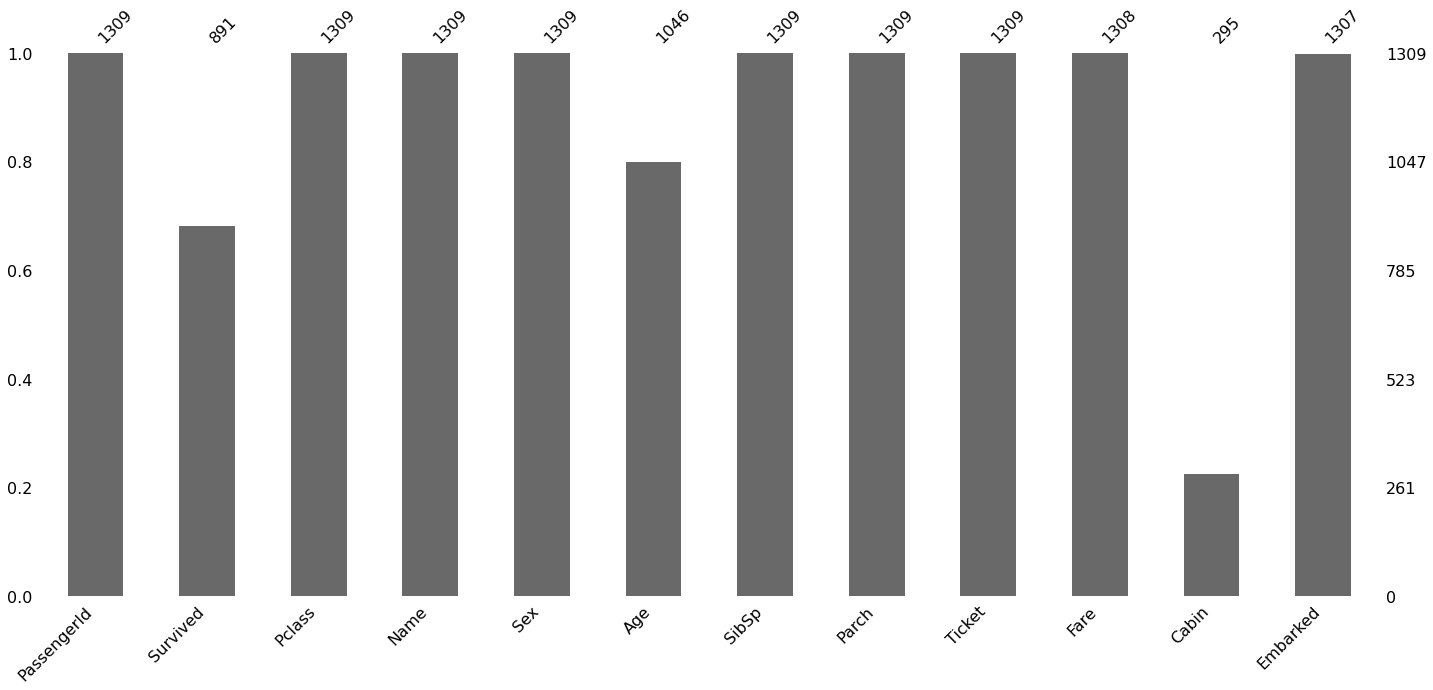

In [360]:
msno.bar(base_all_df)

In [361]:
base_all_df.isna().sum()

PassengerId       0
Survived        418
Pclass            0
Name              0
Sex               0
Age             263
SibSp             0
Parch             0
Ticket            0
Fare              1
Cabin          1014
Embarked          2
dtype: int64

## Feature Engineering

In [362]:
all_df = base_all_df.copy()

### Family size feature

In [363]:
all_df["FamilySize"] = all_df["SibSp"] + all_df["Parch"] +1

In [364]:
all_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,FamilySize
0,1,0.0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,2
1,2,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,2
2,3,1.0,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,1
3,4,1.0,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,2
4,5,0.0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,1


### Title feature


In [365]:
def get_title(name: str):
    return name.split(",")[1].split(".")[0].strip()

In [366]:
all_df["Title"] = all_df["Name"].apply(get_title).astype("string")

In [367]:
all_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1309 entries, 0 to 417
Data columns (total 14 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  1309 non-null   int64  
 1   Survived     891 non-null    float64
 2   Pclass       1309 non-null   int64  
 3   Name         1309 non-null   object 
 4   Sex          1309 non-null   object 
 5   Age          1046 non-null   float64
 6   SibSp        1309 non-null   int64  
 7   Parch        1309 non-null   int64  
 8   Ticket       1309 non-null   object 
 9   Fare         1308 non-null   float64
 10  Cabin        295 non-null    object 
 11  Embarked     1307 non-null   object 
 12  FamilySize   1309 non-null   int64  
 13  Title        1309 non-null   string 
dtypes: float64(3), int64(5), object(5), string(1)
memory usage: 153.4+ KB


## Impute missing values

### Fill "Embarked"

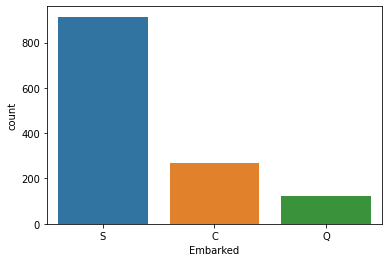

In [368]:
sns.countplot(data=all_df, x="Embarked")

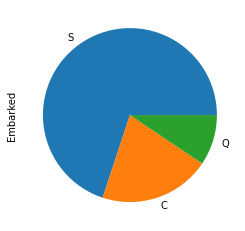

In [369]:
all_df["Embarked"].value_counts().plot.pie()

In [370]:
all_df["Embarked"] = all_df["Embarked"].fillna(all_df["Embarked"].mode().iloc[0])

In [371]:
all_df["Embarked"].isna().sum()

0

### Fill fare

In [372]:
all_df[all_df["Fare"].isna()]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,FamilySize,Title
152,1044,NaN,3,"Storey, Mr. Thomas",male,60.5,0,0,3701,NaN,NaN,S,1,Mr


In [373]:
all_df["Fare"] = all_df.groupby(["Pclass", "FamilySize"]).transform(lambda x: x.fillna(x.median()))["Fare"]

In [374]:
all_df.isna().sum()

PassengerId       0
Survived        418
Pclass            0
Name              0
Sex               0
Age             263
SibSp             0
Parch             0
Ticket            0
Fare              0
Cabin          1014
Embarked          0
FamilySize        0
Title             0
dtype: int64

### Fill Ages

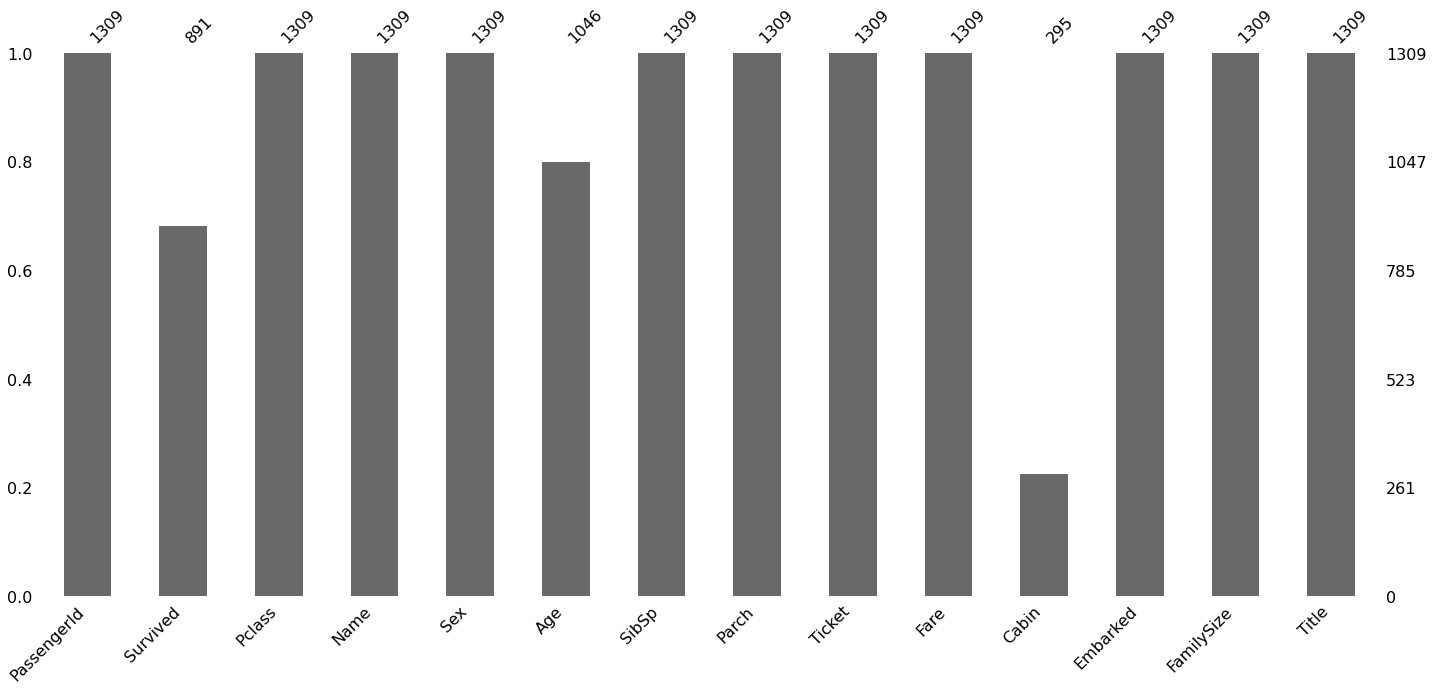

In [375]:
msno.bar(all_df)

In [376]:
all_df["Title"].value_counts()

Mr              757
Miss            260
Mrs             197
Master           61
Dr                8
Rev               8
Col               4
Ms                2
Major             2
Mlle              2
Sir               1
Don               1
Mme               1
Dona              1
the Countess      1
Capt              1
Lady              1
Jonkheer          1
Name: Title, dtype: Int64

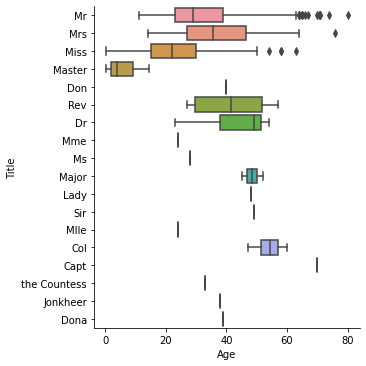

In [377]:
sns.catplot(data=all_df, x="Age", y="Title", kind="box")

In [378]:
all_df["Age"] = all_df.groupby(["Title"]).transform(lambda x: x.fillna(x.median()))["Age"]

In [379]:
all_df.isna().sum()

PassengerId       0
Survived        418
Pclass            0
Name              0
Sex               0
Age               0
SibSp             0
Parch             0
Ticket            0
Fare              0
Cabin          1014
Embarked          0
FamilySize        0
Title             0
dtype: int64

## Drop unused columns

In [380]:
def drop_unused_colunms(dataframe: pd.DataFrame):
    DROP_COLUMNS_NAME = ["Cabin", "Name", "Ticket"]

    return dataframe.drop(columns=DROP_COLUMNS_NAME, errors="ignore")

In [381]:
def drop_label(dataframe: pd.DataFrame, label: str = "PassengerId"):
    return dataframe.drop(columns=[label], errors="ignore")

In [382]:
# Drop columns
all_df = drop_unused_colunms(all_df)
all_df

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,FamilySize,Title
0,1,0.0,3,male,22.0,1,0,7.2500,S,2,Mr
1,2,1.0,1,female,38.0,1,0,71.2833,C,2,Mrs
2,3,1.0,3,female,26.0,0,0,7.9250,S,1,Miss
3,4,1.0,1,female,35.0,1,0,53.1000,S,2,Mrs
4,5,0.0,3,male,35.0,0,0,8.0500,S,1,Mr
...,...,...,...,...,...,...,...,...,...,...,...
413,1305,NaN,3,male,29.0,0,0,8.0500,S,1,Mr
414,1306,NaN,1,female,39.0,0,0,108.9000,C,1,Dona
415,1307,NaN,3,male,38.5,0,0,7.2500,S,1,Mr
416,1308,NaN,3,male,29.0,0,0,8.0500,S,1,Mr


In [383]:
all_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1309 entries, 0 to 417
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  1309 non-null   int64  
 1   Survived     891 non-null    float64
 2   Pclass       1309 non-null   int64  
 3   Sex          1309 non-null   object 
 4   Age          1309 non-null   float64
 5   SibSp        1309 non-null   int64  
 6   Parch        1309 non-null   int64  
 7   Fare         1309 non-null   float64
 8   Embarked     1309 non-null   object 
 9   FamilySize   1309 non-null   int64  
 10  Title        1309 non-null   string 
dtypes: float64(3), int64(5), object(2), string(1)
memory usage: 162.7+ KB


In [384]:
# Currently unused code.
# But remains for later
def remove_nan_rows(dataframe: pd.DataFrame, ratio: int = 0.01):
    small_nan_columns = [x for x, y in dataframe.isna().mean().items() if 0 < y <= ratio]

    return dataframe.dropna(subset=small_nan_columns)

## Set type

In [385]:
all_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1309 entries, 0 to 417
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  1309 non-null   int64  
 1   Survived     891 non-null    float64
 2   Pclass       1309 non-null   int64  
 3   Sex          1309 non-null   object 
 4   Age          1309 non-null   float64
 5   SibSp        1309 non-null   int64  
 6   Parch        1309 non-null   int64  
 7   Fare         1309 non-null   float64
 8   Embarked     1309 non-null   object 
 9   FamilySize   1309 non-null   int64  
 10  Title        1309 non-null   string 
dtypes: float64(3), int64(5), object(2), string(1)
memory usage: 162.7+ KB


In [386]:
string_cols = ["Sex", "Embarked", "Title"]
for name in string_cols:
    all_df[name] = all_df[name].astype("string")

In [387]:
all_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1309 entries, 0 to 417
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  1309 non-null   int64  
 1   Survived     891 non-null    float64
 2   Pclass       1309 non-null   int64  
 3   Sex          1309 non-null   string 
 4   Age          1309 non-null   float64
 5   SibSp        1309 non-null   int64  
 6   Parch        1309 non-null   int64  
 7   Fare         1309 non-null   float64
 8   Embarked     1309 non-null   string 
 9   FamilySize   1309 non-null   int64  
 10  Title        1309 non-null   string 
dtypes: float64(3), int64(5), string(3)
memory usage: 162.7 KB


In [409]:
float_cols = ["SibSp", "Parch", "Fare", "Age", "FamilySize"]

for name in float_cols:
    all_df[name] = all_df[name].astype("float32")

## Split data to train and test

In [410]:
train_df = all_df[all_df[LABEL_NAME].notna()]
train_df

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,FamilySize,Title
0,1,0.0,3,male,22.0,1.0,0.0,7.250000,S,2.0,Mr
1,2,1.0,1,female,38.0,1.0,0.0,71.283302,C,2.0,Mrs
2,3,1.0,3,female,26.0,0.0,0.0,7.925000,S,1.0,Miss
3,4,1.0,1,female,35.0,1.0,0.0,53.099998,S,2.0,Mrs
4,5,0.0,3,male,35.0,0.0,0.0,8.050000,S,1.0,Mr
...,...,...,...,...,...,...,...,...,...,...,...
886,887,0.0,2,male,27.0,0.0,0.0,13.000000,S,1.0,Rev
887,888,1.0,1,female,19.0,0.0,0.0,30.000000,S,1.0,Miss
888,889,0.0,3,female,22.0,1.0,2.0,23.450001,S,4.0,Miss
889,890,1.0,1,male,26.0,0.0,0.0,30.000000,C,1.0,Mr


In [411]:
base_test_df = all_df[all_df[LABEL_NAME].isna()].drop([LABEL_NAME], axis=1)
base_test_df

,PassengerId,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,FamilySize,Title
0,892,3,male,34.5,0.0,0.0,7.829200,Q,1.0,Mr
1,893,3,female,47.0,1.0,0.0,7.000000,S,2.0,Mrs
2,894,2,male,62.0,0.0,0.0,9.687500,Q,1.0,Mr
3,895,3,male,27.0,0.0,0.0,8.662500,S,1.0,Mr
4,896,3,female,22.0,1.0,1.0,12.287500,S,3.0,Mrs
...,...,...,...,...,...,...,...,...,...,...
413,1305,3,male,29.0,0.0,0.0,8.050000,S,1.0,Mr
414,1306,1,female,39.0,0.0,0.0,108.900002,C,1.0,Dona
415,1307,3,male,38.5,0.0,0.0,7.250000,S,1.0,Mr
416,1308,3,male,29.0,0.0,0.0,8.050000,S,1.0,Mr


# Convert `pd.DataFrame` to `tf.data.Dataset`

In [412]:
train, test = train_test_split(train_df, test_size=0.2)
train, val = train_test_split(train, test_size=0.2)

print(len(train), 'train examples')
print(len(val), 'validation examples')
print(len(test), 'test examples')

569 train examples
143 validation examples
179 test examples


In [413]:
def df_to_dataset(dataframe, shuffle=True, batch_size=32):
    dataframe = dataframe.copy()
    labels = dataframe.pop(LABEL_NAME)
    ds = tf.data.Dataset.from_tensor_slices((dict(dataframe), labels))
    if shuffle:
        ds = ds.shuffle(buffer_size=len(dataframe))

    ds = ds.batch(batch_size)
    ds = ds.prefetch(batch_size)
    
    return ds

In [414]:
batch_size = 32
train_ds = df_to_dataset(train_df, batch_size=batch_size)

In [434]:
[(train_features, label_batch)] = train_ds.take(1)
print('Every feature:', list(train_features.keys()))

for k, v in train_features.items():
    print(f"{k}, {v}")

print('A batch of targets:', label_batch )

Every feature: ['PassengerId', 'Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked', 'FamilySize', 'Title']
PassengerId, [564 887 659 880 319 521 586 276 167 479 712 199 885 780 109   9 775 175
 165  18  89 460 225 296 356 662  98 377 502 627 101 766 520 527 180 435
 428 792 601 410 324 647 843 543  26  88 714 357  30 220 889 361 858 772
 861  36 539 764 667 787 364 516 485 235 336 808 135 232  47 457 140 375
   3 277 743   6 630 439 644 724 396 577 455 616  92 834 597 537 196 466
 262 420  72 181 407 173 575 433  15 592 767 110 168 760 314 400 798 522
 355 707 866 507 645 617 612 571 202 762 287 451 836 212 418 639 390 596
 174  53 641 593  23 132 419  13 697 382 610 727 226 318 805 795 734 546
 298  60 114 591 366  82   8  81 710 257 777 618  76 515  12 376 640 666
 638 717  24 354  39 150 489 518 176  37 703 530 875 661 453 112 735 676
 291   5 179 506 481 288 310 583 528 264 206 877 412  63 283 786 440 484
 814  96 341 497 541 463 237 136  14 619 765 536 230 736 670   2 731

# Create layers

In [416]:
def get_normalization_layer(name, dataset):
    # Create a Normalizatoin layer for our feature.
    normalizer = preprocessing.Normalization()

    feature_ds = dataset.map(lambda x, y: x[name])

    normalizer.adapt(feature_ds)

    return normalizer

In [417]:
# age_column = train_features["Fare"]
# layer = get_normalization_layer("Fare", train_ds)
# layer(age_column)

In [418]:
def get_category_encoding_layer(name, dataset, dtype, max_tokens=None):
    if dtype == "string":
        index = preprocessing.StringLookup(max_tokens=max_tokens)
    else:
        index = preprocessing.IntegerLookup(max_values=max_tokens)

    feature_ds = dataset.map(lambda x, y: x[name])

    index.adapt(feature_ds)

    encoder = preprocessing.CategoryEncoding(max_tokens=index.vocab_size())

    feauter_ds = feature_ds.map(index)

    encoder.adapt(feature_ds)

    return lambda feature: encoder(index(feature))

In [419]:
sex_colunms = train_features["Sex"]
category_encoding_layer = get_category_encoding_layer("Sex", train_ds, "string")

category_encoding_layer(sex_colunms)

<tf.Tensor: shape=(32, 4), dtype=float32, numpy=
array([[0., 0., 0., 1.],
       [0., 0., 0., 1.],
       [0., 0., 1., 0.],
       [0., 0., 1., 0.],
       [0., 0., 1., 0.],
       [0., 0., 1., 0.],
       [0., 0., 1., 0.],
       [0., 0., 1., 0.],
       [0., 0., 1., 0.],
       [0., 0., 1., 0.],
       [0., 0., 0., 1.],
       [0., 0., 0., 1.],
       [0., 0., 1., 0.],
       [0., 0., 1., 0.],
       [0., 0., 0., 1.],
       [0., 0., 1., 0.],
       [0., 0., 1., 0.],
       [0., 0., 0., 1.],
       [0., 0., 1., 0.],
       [0., 0., 1., 0.],
       [0., 0., 0., 1.],
       [0., 0., 1., 0.],
       [0., 0., 1., 0.],
       [0., 0., 0., 1.],
       [0., 0., 1., 0.],
       [0., 0., 0., 1.],
       [0., 0., 1., 0.],
       [0., 0., 0., 1.],
       [0., 0., 0., 1.],
       [0., 0., 1., 0.],
       [0., 0., 1., 0.],
       [0., 0., 1., 0.]], dtype=float32)>

In [420]:
batch_size = 256
train_ds = df_to_dataset(train, batch_size=batch_size)
val_ds = df_to_dataset(val, shuffle=False, batch_size=batch_size)
test_ds = df_to_dataset(test, shuffle=False, batch_size=batch_size)

In [421]:
all_inputs = []
encoded_features = []

numeric_cols = ["SibSp", "Parch", "Fare", "Age", "FamilySize"]

# Numeric features
for header in numeric_cols:
    numeric_col = tf.keras.Input(shape=(1,), name=header)
    normalization_layer = get_normalization_layer(header, train_ds)
    encoded_numeric_col = normalization_layer(numeric_col)

    all_inputs.append(numeric_col)
    encoded_features.append(encoded_numeric_col)

In [422]:
# Categorical features as string
categorical_cols = {
    "Sex": "string",
    "Embarked": "string",
    "Title": "string",
    "Pclass": "int64",
}

for header, dtype in categorical_cols.items():
    categorical_col = tf.keras.Input(shape=(1,), name=header, dtype=dtype)
    encoding_layer = get_category_encoding_layer(header, train_ds, dtype=dtype)

    encoded_categorical_col = encoding_layer(categorical_col)

    all_inputs.append(categorical_col)
    encoded_features.append(encoded_categorical_col)

# Categorical features as int


In [423]:
all_inputs

[<KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'SibSp')>,
 <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'Parch')>,
 <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'Fare')>,
 <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'Age')>,
 <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'FamilySize')>,
 <KerasTensor: shape=(None, 1) dtype=string (created by layer 'Sex')>,
 <KerasTensor: shape=(None, 1) dtype=string (created by layer 'Embarked')>,
 <KerasTensor: shape=(None, 1) dtype=string (created by layer 'Title')>,
 <KerasTensor: shape=(None, 1) dtype=int64 (created by layer 'Pclass')>]

In [424]:
encoded_features

[<KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'normalization_30')>,
 <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'normalization_31')>,
 <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'normalization_32')>,
 <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'normalization_33')>,
 <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'normalization_34')>,
 <KerasTensor: shape=(None, 4) dtype=float32 (created by layer 'category_encoding_34')>,
 <KerasTensor: shape=(None, 5) dtype=float32 (created by layer 'category_encoding_35')>,
 <KerasTensor: shape=(None, 16) dtype=float32 (created by layer 'category_encoding_36')>,
 <KerasTensor: shape=(None, 5) dtype=float32 (created by layer 'category_encoding_37')>]

In [425]:
sequential_layer = tf.keras.Sequential([
    tf.keras.layers.Dense(16, activation=tf.keras.activations.relu),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(8, activation=tf.keras.activations.relu),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1, activation=tf.keras.activations.sigmoid),
])

all_layers = sequential_layer(tf.keras.layers.concatenate(encoded_features))

model = tf.keras.Model(inputs=all_inputs, outputs=all_layers)

model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=True), 
    metrics=[tf.keras.metrics.BinaryAccuracy()],
)

model.summary()

Model: "model_8"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Sex (InputLayer)                [(None, 1)]          0                                            
__________________________________________________________________________________________________
Embarked (InputLayer)           [(None, 1)]          0                                            
__________________________________________________________________________________________________
Title (InputLayer)              [(None, 1)]          0                                            
__________________________________________________________________________________________________
Pclass (InputLayer)             [(None, 1)]          0                                            
____________________________________________________________________________________________

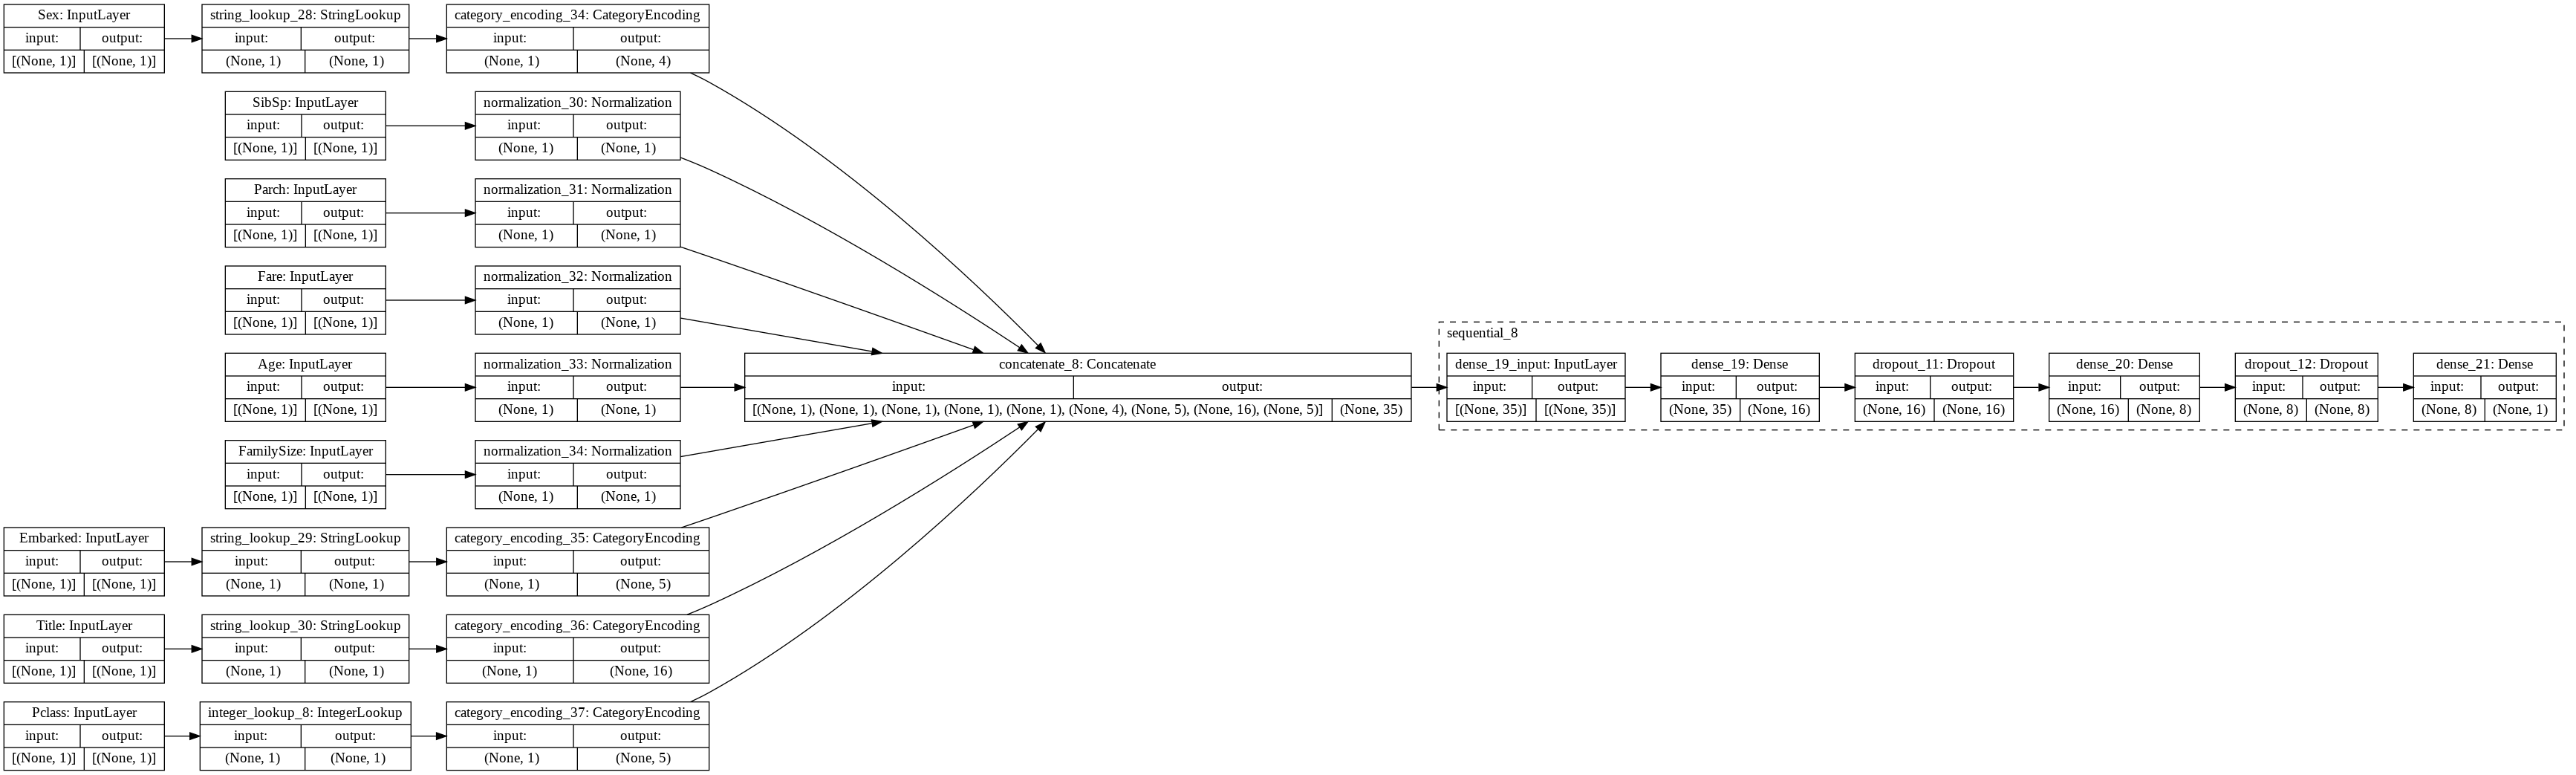

In [426]:
# rankdir='LR' is used to make the graph horizontal.
tf.keras.utils.plot_model(
    model,
    show_shapes=True,
    rankdir="LR",
    expand_nested=True
)

In [427]:
import datetime

log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(
    log_dir=log_dir,
    histogram_freq=1,
)

In [428]:
# tf.config.set_soft_device_placement(True)
# tf.debugging.experimental.enable_dump_debug_info(
#     "tmp/tfdbg2_dump",
#     tensor_debug_mode="FULL_HEALTH",
#     circular_buffer_size=-1
# )


In [429]:
tf.debugging.enable_check_numerics(
    stack_height_limit=50, path_length_limit=50
)

INFO:tensorflow:Enabled check-numerics callback in thread MainThread


# Check model

In [430]:
test_df = base_test_df.copy()

In [431]:
id = test_df.pop("PassengerId")

In [432]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 418 entries, 0 to 417
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Pclass      418 non-null    int64  
 1   Sex         418 non-null    string 
 2   Age         418 non-null    float32
 3   SibSp       418 non-null    float32
 4   Parch       418 non-null    float32
 5   Fare        418 non-null    float32
 6   Embarked    418 non-null    string 
 7   FamilySize  418 non-null    float32
 8   Title       418 non-null    string 
dtypes: float32(5), int64(1), string(3)
memory usage: 24.5 KB


In [445]:
submission_ds = tf.data.Dataset.from_tensor_slices(test_df.to_dict("list")).batch(32)

In [446]:
for features in submission_ds.take(3):
    print(f"{features}")

{'Pclass': <tf.Tensor: shape=(32,), dtype=int32, numpy=
array([3, 3, 2, 3, 3, 3, 3, 2, 3, 3, 3, 1, 1, 2, 1, 2, 2, 3, 3, 3, 1, 3,
       1, 1, 1, 3, 1, 3, 1, 3, 2, 2], dtype=int32)>, 'Sex': <tf.Tensor: shape=(32,), dtype=string, numpy=
array([b'male', b'female', b'male', b'male', b'female', b'male',
       b'female', b'male', b'female', b'male', b'male', b'male',
       b'female', b'male', b'female', b'female', b'male', b'male',
       b'female', b'female', b'male', b'male', b'female', b'male',
       b'female', b'male', b'female', b'male', b'male', b'male', b'male',
       b'male'], dtype=object)>, 'Age': <tf.Tensor: shape=(32,), dtype=float32, numpy=
array([34.5, 47. , 62. , 27. , 22. , 14. , 30. , 26. , 18. , 21. , 29. ,
       46. , 23. , 63. , 47. , 24. , 35. , 21. , 27. , 45. , 55. ,  9. ,
       35.5, 21. , 48. , 50. , 22. , 22.5, 41. , 29. , 50. , 24. ],
      dtype=float32)>, 'SibSp': <tf.Tensor: shape=(32,), dtype=float32, numpy=
array([0., 1., 0., 0., 1., 0., 0., 1., 0., 2., 

In [447]:
model.predict(submission_ds)

array([[0.50968],
       [0.36289],
       [0.43135],
       [0.47632],
       [0.34867],
       [0.47907],
       [0.46812],
       [0.34479],
       [0.36756],
       [0.44621],
       [0.47551],
       [0.44578],
       [0.30906],
       [0.35878],
       [0.32378],
       [0.32584],
       [0.44166],
       [0.47573],
       [0.43903],
       [0.39117],
       [0.44133],
       [0.5059 ],
       [0.37159],
       [0.36189],
       [0.10521],
       [0.4444 ],
       [0.40911],
       [0.47636],
       [0.44118],
       [0.47184],
       [0.35471],
       [0.31197],
       [0.33131],
       [0.32579],
       [0.43534],
       [0.47467],
       [0.43972],
       [0.43979],
       [0.47695],
       [0.40197],
       [0.50545],
       [0.42779],
       [0.46733],
       [0.33901],
       [0.32654],
       [0.47881],
       [0.45155],
       [0.50739],
       [0.37753],
       [0.32265],
       [0.43808],
       [0.44955],
       [0.40444],
       [0.21945],
       [0.44791],
       [0.

# Train model

In [448]:
history = model.fit(train_ds,
    epochs = 300,
    validation_data = val_ds,
    callbacks = [
        tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=10)
    ],
)

Epoch 1/300


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/functional.py:595: UserWarning: Input dict contained keys ['PassengerId'] which did not match any model input. They will be ignored by the model.
  [n for n in tensors.keys() if n not in ref_input_names])


3/3 [==============================] - 3s 393ms/step - loss: 0.8212 - binary_accuracy: 0.5103 - val_loss: 0.7184 - val_binary_accuracy: 0.5524
Epoch 2/300
3/3 [==============================] - 0s 23ms/step - loss: 0.7727 - binary_accuracy: 0.5435 - val_loss: 0.7114 - val_binary_accuracy: 0.5944
Epoch 3/300
3/3 [==============================] - 0s 22ms/step - loss: 0.7762 - binary_accuracy: 0.5442 - val_loss: 0.7049 - val_binary_accuracy: 0.5944
Epoch 4/300
3/3 [==============================] - 0s 23ms/step - loss: 0.7774 - binary_accuracy: 0.5538 - val_loss: 0.6989 - val_binary_accuracy: 0.5874
Epoch 5/300
3/3 [==============================] - 0s 25ms/step - loss: 0.7603 - binary_accuracy: 0.5611 - val_loss: 0.6938 - val_binary_accuracy: 0.5874
Epoch 6/300
3/3 [==============================] - 0s 24ms/step - loss: 0.7494 - binary_accuracy: 0.5741 - val_loss: 0.6894 - val_binary_accuracy: 0.5874
Epoch 7/300
3/3 [==============================] - 0s 24ms/step - loss: 0.6955 - binary

In [449]:
model.evaluate(test_ds, verbose=2)

1/1 - 0s - loss: 0.3900 - binary_accuracy: 0.8492


[0.39003974199295044, 0.8491619825363159]

# keras.predict() with test.csv

In [456]:
submission_ds = tf.data.Dataset.from_tensor_slices(test_df.to_dict("list")).batch(32)

In [458]:
y_prob = model.predict(submission_ds)
y_prob

array([[0.10762],
       [0.47278],
       [0.07207],
       [0.13471],
       [0.57929],
       [0.14087],
       [0.57529],
       [0.11937],
       [0.71973],
       [0.07073],
       [0.13243],
       [0.3152 ],
       [0.76861],
       [0.07389],
       [0.69634],
       [0.75319],
       [0.10636],
       [0.2565 ],
       [0.45697],
       [0.59694],
       [0.3504 ],
       [0.56312],
       [0.72949],
       [0.57418],
       [0.79148],
       [0.07002],
       [0.7655 ],
       [0.25003],
       [0.35341],
       [0.08994],
       [0.08647],
       [0.07856],
       [0.54289],
       [0.5393 ],
       [0.55711],
       [0.26651],
       [0.55852],
       [0.56606],
       [0.13704],
       [0.16043],
       [0.19292],
       [0.43386],
       [0.12002],
       [0.71811],
       [0.69368],
       [0.1368 ],
       [0.43596],
       [0.11585],
       [0.7433 ],
       [0.5728 ],
       [0.49798],
       [0.27618],
       [0.62887],
       [0.75522],
       [0.26022],
       [0.

In [464]:
prediction_df = pd.DataFrame({
    "PassengerId": id,
    "Prob": y_prob.flatten()
})

In [465]:
prediction_df

,PassengerId,Prob
0,892,0.107616
1,893,0.472783
2,894,0.072066
3,895,0.134709
4,896,0.579285
...,...,...
413,1305,0.132449
414,1306,0.748582
415,1307,0.122438
416,1308,0.132449


In [467]:
prediction_df[LABEL_NAME] = prediction_df["Prob"].apply(lambda x: 1 if x >= 0.5 else 0)

In [469]:
submission_df = prediction_df.drop("Prob", axis=1)
submission_df

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,1
...,...,...
413,1305,0
414,1306,1
415,1307,0
416,1308,0


In [471]:
submission_df.to_csv(os.path.join(DATA_DIR, "submission.csv"), index=False)

# Reference

[Classify structured data using Keras Preprocessing Layers](https://www.tensorflow.org/tutorials/structured_data/preprocessing_layers)

- <https://medium.com/@kyawsawhtoon/a-guide-to-knn-imputation-95e2dc496e>
- <https://www.kaggle.com/allohvk/titanic-missing-age-imputation-tutorial-advanced>
- <https://www.linkedin.com/pulse/learning-data-science-kaggles-titantic-machine-from-disaster-lao>
- <https://towardsdatascience.com/a-beginners-guide-to-kaggle-s-titanic-problem-3193cb56f6ca>
- <http://rstudio-pubs-static.s3.amazonaws.com/334362_1c0190cd668846cda263623feaca61f5.html>
- <https://machinelearningmastery.com/handle-missing-data-python/>
- <https://michael-hoffman.github.io/titanic/#second-bullet>
- <https://www.kaggle.com/jamesleslie/titanic-eda-wrangling-imputation>
- <https://becominghuman.ai/titanic-survival-dataset-part-2-2-logistic-regression-7ebe9e30bf54>
- <https://towardsdatascience.com/kaggle-titanic-machine-learning-model-top-7-fa4523b7c40>